In [38]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

%matplotlib inline

In [40]:
def nuInt(x, k):
    #print ((k-1)*((k**2-6*k+6.)))
    #print ((k**2-3*k+2)*np.power(x,2)+2*(k-1.)*x+2)
    #return -np.power((x+1.), (1-k))*((k**2-3.*k+2)*np.power(x,2)+2*(k-1.)*x+2)/((k-1.)*(k**2-5*k+6.))
    #this is assuming k=-3 
    #return -1./(2.*(r_lim+1.)**2)
    return np.power(x,3-k)/(3-k)

def nuProfile(Ntot,radii,k=2.9):
    nu0 = Ntot / (4.*np.pi*(nuInt(radii[-1], k)-nuInt(radii[0], k)))
    print nu0
    #print 'nu0:' ,nu0
    return (nu0*(nuInt(radii[1:],k) - nuInt(radii[:-1],k))).astype(int)

#radii = np.append(0.,np.logspace(1.,3.,11))
radii = np.logspace(1.,3.,11)
#plt.xscale('log')
#plt.yscale('log')
#plt.plot(radii[1:],nuProfile(1000,radii),'b+')
print "log spaced bins"
print radii
print nuProfile(1000,radii)
print np.sum(nuProfile(1000,radii))
radii_lin = np.linspace(10,1000, 11)
print "lin spaces bins"
print radii_lin
print nuProfile(1000,radii_lin)
print np.sum(nuProfile(1000,radii_lin))

# here I conclude that the logspace is not ideal - if we want nicer bins, we should create ones that
# sample the volume in a log way - so that our sample is equally spread out 


log spaced bins
[   10.            15.84893192    25.11886432    39.81071706    63.09573445
   100.           158.48931925   251.18864315   398.10717055   630.95734448
  1000.        ]
10.807209472
[6 6 7 7 7 8 8 8 9 9]
10.807209472
75
lin spaces bins
[   10.   109.   208.   307.   406.   505.   604.   703.   802.   901.
  1000.]
10.807209472
[36 11  7  5  4  3  3  2  2  2]
10.807209472
75


In [41]:
def defineRadii(nTot=1000.,rOut=1000.,nAnn=10,k=2.9):
    radii = np.array([1.])
    nu0 = nTot*(3.-k)/(4*np.pi*(rOut**(3.-k)-1.))
    c = (3-k)*nTot/(4*np.pi*nu0*nAnn)
    for i in range(nAnn):
        radii = np.append(radii,(c+radii[i]**(3-k))**(1./(3-k)))
    return radii
    
print defineRadii()

[  1.00000000e+00   2.58259287e+00   6.14301895e+00   1.36358662e+01
   2.85362998e+01   5.67608209e+01   1.08013279e+02   1.97700912e+02
   3.49599450e+02   5.99485613e+02   1.00000000e+03]


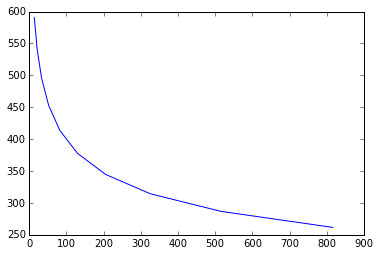

In [42]:
def sigmaProfile(radii,sigMax=1000,k=-.2):
    
    return sigMax*(1.+0.5*(radii[1:]+radii[:-1]))**k

plt.plot(1.+0.5*(radii[1:]+radii[:-1]),sigmaProfile(radii))

In [43]:
def createMockData(Ntot=1000,rOut=1000.,shells=10,sigMax=1000,kindex=2.9,sigmaindex=-0.2): #total Ngals, no of shells
    clusterData = np.zeros((2*Ntot,5))
    counter=0
    radii = defineRadii(Ntot,rOut,shells,kindex)
    #density = nuProfile(Ntot,radii,k=kindex)
    sig = sigmaProfile(radii,sigMax=1000,k=sigmaindex)
    
    for shell,dens in enumerate((Ntot/shells)*np.ones(shells)):
        #generate positions
        phi = np.random.uniform(0.,2*np.pi,dens)
        cosTheta = np.random.uniform(-1,1,dens)
        theta = np.arccos(cosTheta)
        u = np.random.uniform(radii[shell]**3,radii[shell+1]**3,dens) #cuberoot([rin,rout])
        r = np.power(u,1./3)
        
        x = r*np.sin(theta)*np.cos(phi)
        y = r*np.sin(theta)*np.sin(phi)
        z = r*cosTheta
        
        #generate velocities
        
        speed = sig[shell]*np.random.randn(dens)
        #phi = np.random.uniform(0.,2*np.pi,dens)
        cosTheta = np.random.uniform(-1,1,dens)
        #theta = np.arccos(cosTheta)
        
        v=speed*cosTheta   
        
        #replace with vstack,append
        clusterData[counter:counter+dens]=np.hstack((shell*np.ones(dens).reshape((dens,1)),x.reshape((dens,1)),y.reshape((dens,1)),z.reshape((dens,1)),v.reshape((dens,1))))
        counter += dens
    
    print counter
    return clusterData[:counter],sig

In [46]:
cluster,sigma = createMockData()

print np.logspace(-2,1,11)

plt.scatter(cluster[:,1],cluster[:,2],s=np.fabs(cluster[:4])/5)

1000.0


/home/ondrej/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:10: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/ondrej/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:11: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/ondrej/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:13: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/ondrej/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:22: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/ondrej/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:24: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/ondrej/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:30: Deprecati

NameError: global name 'density' is not defined

In [32]:
import pandas as pd

clusterPd = pd.DataFrame(cluster)

clusterPd.describe()

,0,1,2,3,4
count,1101.000000,1101.000000,1101.000000,1101.000000,1101.000000
mean,5.695731,0.028912,0.029433,0.037872,-5.632199
std,2.079132,1.078597,0.980062,0.954365,525.847828
min,0.000000,-7.585694,-7.151037,-7.848254,-2087.923546
25%,4.000000,-0.182506,-0.158961,-0.180954,-231.613649
50%,6.000000,-0.002792,0.004527,-0.002512,-7.440003
75%,7.000000,0.158644,0.185548,0.196845,212.585200
max,10.000000,9.350571,7.673212,8.496440,2930.312825


In [33]:
#clusterPd.to_csv('mock_cluster.csv')
clusterPd.to_csv('mock_cluster_3.csv')